In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import pandas as pd
from random import random, seed

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import sklearn.linear_model as skl

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils import resample

## 1. Setting up the data

We start with the visualisation of the data given in the project. 

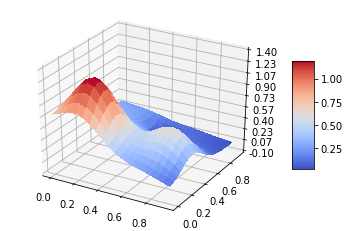

In [2]:
# Make data: 
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

z = FrankeFunction(x, y)

# Plot data: 
fig = plt.figure()
ax = fig.gca(projection='3d')

surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Then we create the design matrix with a given number of points (n_x) and a given polynomial. 

In [3]:
def CreateDesignMatrix_X(x, y, n):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)
        
    N = len(x)
    l = int((n+1)*(n+2)/2)
    X = np.ones((N,l))
        
    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = x**(i-k) * y**k
    return X

In [4]:
n_x = 250   # number of points

x = np.linspace(0, 1, n_x)
y = np.linspace(0, 1, n_x)

x, y = np.meshgrid(x,y)
z = FrankeFunction(x,y)

# Transform from matrices to vectors
x_1 = np.ravel(x)
y_1 = np.ravel(y)
n = int(len(x_1))
z_true = np.ravel(z)
z_1 = np.ravel(z) + np.random.normal(size=n) * 1

In [5]:
m = 5  # degree of polynomial
X = CreateDesignMatrix_X(x_1, y_1, n=m)

z_1 is the function that gives the data (y), X is the design matrix

We start with some basic OLS (no resampling, no splitting)

In [6]:
# For the noisy function
beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(z_1)
ztilde = X @ beta

# For the true function (without the noise)
beta_t = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(z_true)
ztilde_t = X @ beta_t

Set up the functions for the MSE and the R2-score

In [7]:
def MSE(z_data, z_model):
    n = np.size(z_model)
    return np.sum((z_data-z_model)**2)/n
print(MSE(z_true, ztilde))

def R2(z_data, z_model):
    return 1 - np.sum((z_data - z_model) ** 2) / np.sum((z_data - np.mean(z_model)) ** 2)
print(R2(z_true, ztilde))

0.002382868645019189
0.971108847889149


Then we split the data in train and test

In [8]:
X_train, X_test, z_train, z_test, z_true_train, z_true_test = train_test_split(X, z_1, z_true, test_size=0.2)

# Get the new model from the training data
beta1 = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train)
ztilde1 = X_train @ beta1

# And the predictions for the test data
zpredict = X_test @ beta1

print("Training MSE: %0.4f" % MSE(z_train, ztilde1))
print("Test MSE: %0.4f" % MSE(z_test, zpredict))
print("True MSE: %0.4f" % MSE(z_true_test, zpredict))

print("Training R2: %0.4f" % R2(z_train, ztilde1))
print("Test R2: %0.4f" % R2(z_test, zpredict))
print("True R2: %0.4f" % R2(z_true_test, zpredict))

Training MSE: 1.0020
Test MSE: 0.9946
True MSE: 0.0023
Training R2: 0.0757
Test R2: 0.0817
True R2: 0.9712


### 1.1 Plot of the data

We visualize the fit of the OLS regression. In order to do so we set back the number of points for the design matrix to a 100, because otherwise there are too much scattered dots in the plot. 

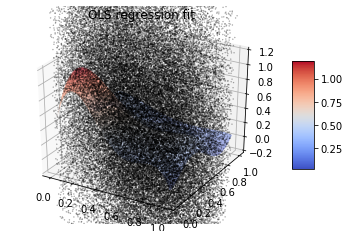

In [9]:
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.set_zlim3d(-0.2, 1.2)

"""
ax1.scatter(x, y, z, 
           alpha=0.5, 
           s=0.1, 
           color='black'
           )
"""
ax1.scatter(x, y, z_1.reshape(x.shape), 
           alpha=0.5, 
           s=0.1, 
           color='black'
           )
#"""
ax1.plot_surface(x, y, ztilde.reshape(x.shape), 
                alpha=0.5, 
                cmap=cm.coolwarm,
                )
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.title(f'OLS regression fit')
plt.show()

## 2. K-fold cross validation

Here we set up our k-fold cross-validation function. We can later call the function with our noisy data. 
We use pinv for the matrix inversion.

In [10]:
# Initialize a KFold instance
k = 10
kfold = KFold(n_splits = k, shuffle=True)

In [11]:
def cross_validation(x, y, k):
    n = len(x)
    
    indexes = np.arange(y.shape[0])
    np.random.shuffle(indexes)
    x = x[indexes]
    y = y[indexes]
    
    r2_train = []
    r2_test = []
    mse_train = []
    mse_test = []
    
    bias = []
    variance = []
    for i in range(k):
        x_train = np.concatenate((x[:int(i*n/k)], x[int((i + 1)*n/k): ]), axis = 0)
        x_test = x[int(i*n/k):int((i + 1)*n/k)]
        y_train = np.concatenate((y[:int(i*n/k)], y[int((i + 1)*n/k): ]), axis = 0)
        y_test = y[int(i*n/k):int((i + 1)*n/k)]

        beta = np.linalg.pinv(x_train.T.dot(x_train)).dot(x_train.T).dot(y_train)
        ytilde = x_train @ beta
        ypredict = x_test @ beta
        
        mse_train.append(MSE(y_train, ytilde))
        mse_test.append(MSE(y_test, ypredict))
        
        r2_train.append(R2(y_train, ytilde))
        r2_test.append(R2(y_test, ypredict))
        
        bias.append(np.mean((y_test - np.mean(ypredict))**2))
        variance.append(np.mean(np.var(ypredict)))
    
    r2_train = np.array(r2_train)
    r2_test = np.array(r2_test)
    mse_train = np.array(mse_train)
    mse_test = np.array(mse_test)
    
    bias = np.array(bias)
    variance = np.array(variance)
        
    return r2_test, mse_train, mse_test, bias, variance, r2_train

In [12]:
r, m_train, m_test, b, v, r_train = cross_validation(X, z_1, k)

print("MSE-score train data: %0.5f (+/- %0.5f)" % (m_train.mean(), m_train.std()*2))
print("MSE-score test data: %0.5f (+/- %0.5f)" % (m_test.mean(), m_test.std()*2))

print("R2-Score train data: %0.5f (+/- %0.5f)" % (r_train.mean(), r_train.std()*2))
print("R2-Score test data: %0.5f (+/- %0.5f)" % (r.mean(), r.std()*2))


MSE-score train data: 1.00034 (+/- 0.00499)
MSE-score test data: 1.00120 (+/- 0.04506)
R2-Score train data: 0.07707 (+/- 0.00148)
R2-Score test data: 0.07625 (+/- 0.01305)


Then we use the cross-validation of skLearn to control our own function. 

In [13]:
linreg = skl.LinearRegression()
linreg.fit(X_train, z_train)

predictions = linreg.predict(X_test)

In [14]:
cv_scores_R2_sklearn = cross_val_score(linreg, X, z_1, cv = kfold)
cv_scores_mse_sklearn = cross_val_score(linreg, X, z_1, scoring='neg_mean_squared_error', cv=kfold)

print("R2-Score noisy data: %0.5f (+/- %0.5f)" % (cv_scores_R2_sklearn.mean(), cv_scores_R2_sklearn.std() * 2))
print('MSE-score noisy data: %0.5f (+/- %0.5f)' % (-cv_scores_mse_sklearn.mean(), cv_scores_mse_sklearn.std() * 2))

R2-Score noisy data: 0.07637 (+/- 0.00783)
MSE-score noisy data: 1.00111 (+/- 0.02496)


## 3. Complexity of the model

First for the true data, without cross-validation, to visualize. 

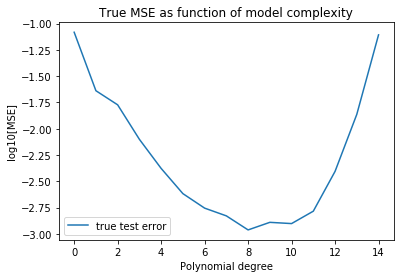

In [15]:
maxdegree = 15

true_mse = np.zeros(maxdegree)
polynomial = np.zeros(maxdegree)

for degree in range(maxdegree):
    X1 = CreateDesignMatrix_X(x_1, y_1, n=degree)

    X1_train, X1_test, z1_train, z1_test, z1_true_train, z1_true_test = train_test_split(X1, z_1, z_true, test_size=0.2)
    beta2 = np.linalg.inv(X1_train.T.dot(X1_train)).dot(X1_train.T).dot(z1_train)
    ztilde1 = X1_train @ beta2
    zpredict1 = X1_test @ beta2
    
    polynomial[degree] = degree
    true_mse[degree] = MSE(z1_true_test, zpredict1)

plt.plot(polynomial, np.log10(true_mse), label='true test error')

plt.xlabel('Polynomial degree')
plt.ylabel('log10[MSE]')
plt.title('True MSE as function of model complexity')
plt.legend()
plt.show()

#### And with cross-validation, for the training and test data

/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


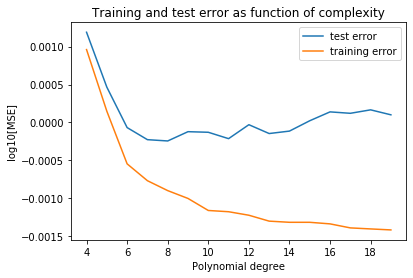

In [16]:
# train and test error

maxdegree = 20
test_mse = np.zeros(maxdegree)
train_mse = np.zeros(maxdegree)
polynomial = np.zeros(maxdegree)

for degree in range(4, maxdegree):
    X1 = CreateDesignMatrix_X(x_1, y_1, n=degree)
        
    polynomial[degree] = degree
    train_mse[degree] = np.mean(cross_validation(X1, z_1, k)[1])
    test_mse[degree] = np.mean(cross_validation(X1, z_1, k)[2])

plt.plot(polynomial, np.log10(test_mse), label='test error')
plt.plot(polynomial, np.log10(train_mse), label='training error')

plt.xlabel('Polynomial degree')
plt.ylabel('log10[MSE]')
plt.title('Training and test error as function of complexity')

plt.legend()
plt.show()

## 4. Bias-variance tradeoff 

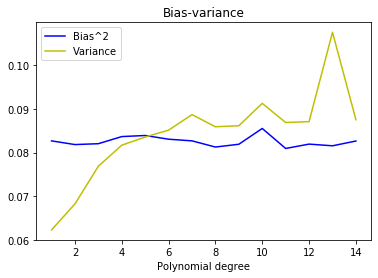

In [17]:
degrees = np.arange(1,15)

X_trainz, X_testz, y_trainz, y_testz = train_test_split(X, z_1,test_size=1./k)
array_size_thingy=len(y_testz)

z_1_ = z_1.reshape(-1,1)
z_true_ = z_true.reshape(-1,1)

error = []
bias = []
variance = []
for deg in degrees:
    z_pred = np.empty((array_size_thingy, k))
    
    j=0
    X3 = CreateDesignMatrix_X(x_1, y_1, n=deg)
    model = skl.LinearRegression()

    for train_inds, test_inds in kfold.split(z_1):
        xtrain = X3[train_inds]
        ztrain= z_1_[train_inds]
        xtest = X3[test_inds]
        ztest = z_1_[test_inds]
        ztruetrain = z_true_[train_inds]
        ztruetest = z_true_[test_inds]
        
        z_pred[:,j] = model.fit(xtrain, ztrain).predict(xtest).ravel()
        
        j+=1

    err = np.mean(np.mean((ztest - z_pred)**2))
    bi = np.mean((ztruetest - np.mean(z_pred))**2)
    var = np.mean(np.var(z_pred))
    
    error.append(err)
    bias.append(bi)
    variance.append(var)

max_pd = 15 #max polynomial degree to plot to

plt.figure()
#plt.plot(degrees[:max_pd],np.log10(error)[:max_pd],'k',label='MSE')
plt.plot(degrees[:max_pd],bias[:max_pd],'b',label='Bias^2')
plt.plot(degrees[:max_pd],variance[:max_pd],'y',label='Variance')
plt.title('Bias-variance')

plt.xlabel('Polynomial degree')
#plt.ylabel('log10[MSE]')
plt.legend()
plt.show()

### New OLS regression with CV

We create a new design matrix with a polynomial of 7, which proved to give the lowest error. We calculate the new MSE score.

In [18]:
m = 7  # degree of polynomial
X_new = CreateDesignMatrix_X(x_1, y_1, n=m)

In [19]:
r, m_train, m_test, b, v, r_train = cross_validation(X, z_1, k)
print("R2-Score poly 5: %0.5f (+/- %0.5f)" % (r.mean(), r.std()*2))
print("MSE-score poly 5: %0.5f (+/- %0.5f)" % (m_test.mean(), m_test.std()*2))

R2-Score poly 5: 0.07639 (+/- 0.01723)
MSE-score poly 5: 1.00112 (+/- 0.04281)


In [20]:
r2_ols, mse_train_ols, mse_test_ols, bias_ols, var_ols, r2_ols_train = cross_validation(X_new, z_1, k)
print("R2-Score poly 8: %0.5f (+/- %0.5f)" % (r2_ols.mean(), r2_ols.std()*2))
print("MSE-score poly 8: %0.5f (+/- %0.5f)" % (mse_test_ols.mean(), mse_test_ols.std()*2))

R2-Score poly 8: 0.07798 (+/- 0.01140)
MSE-score poly 8: 0.99939 (+/- 0.04127)


We compare the scores with sk-learn

In [21]:
linreg = skl.LinearRegression()
mse_OLS_sklearn = cross_val_score(linreg, X_new, z_1, scoring='neg_mean_squared_error', cv=kfold)

print("MSE-score OLS sklearn: %0.5f (+/- %0.5f)" % (-(mse_OLS_sklearn.mean()), mse_OLS_sklearn.std()*2))

MSE-score OLS sklearn: 0.99962 (+/- 0.02723)


And then we have a look at the real data (which we cannot do with cross-validation)

In [22]:
X_new_train, X_new_test, z_new_train, z_new_test, z_new_true_train, z_new_true_test = train_test_split(X_new, z_1, z_true, test_size=0.2)

beta1_new = np.linalg.pinv(X_new_train.T.dot(X_new_train)).dot(X_new_train.T).dot(z_new_train)
zpredict_new = X_new_test @ beta1_new

print("True MSE poly 5: %0.4f" % MSE(z_true_test, zpredict))
print("True MSE poly 8: %0.4f" % MSE(z_new_true_test, zpredict_new))

print("True R2 poly 5: %0.4f" % R2(z_true_test, zpredict))
print("True R2 poly 8: %0.4f" % R2(z_new_true_test, zpredict_new))

True MSE poly 5: 0.0023
True MSE poly 8: 0.0014
True R2 poly 5: 0.9712
True R2 poly 8: 0.9832


## 5. Ridge Regression

First we set up our own function for Ridge and check this one with sklearn. Then we can use this one as basis for more calculations. 

In [23]:
_lambda = 1e-7

In [24]:
X_train_r, X_test_r = X_new_train, X_new_test

betaridge = np.linalg.inv(X_train_r.T.dot(X_train_r)+(_lambda*np.eye(len(X_train_r[0])))).dot(X_train_r.T).dot(z_new_train)
zridge = X_train_r @ betaridge

ridge_predict = X_test_r @ betaridge

In [25]:
print("var(beta) OLS:", np.var(beta1_new))
print("var(beta) ridge:", np.var(betaridge))

var(beta) OLS: 168999.14484033824
var(beta) ridge: 163202.02943250537


In [26]:
print("MSE OLS:", MSE(z_new_test, zpredict_new))
print("MSE-score Ridge:", MSE(z_new_test, ridge_predict))

print("R2-score OLS:", R2(z_new_test, zpredict_new))
print("R2-score Ridge", R2(z_new_test, ridge_predict))

MSE OLS: 0.9813030035239146
MSE-score Ridge: 0.98127636982522
R2-score OLS: 0.07527840155516496
R2-score Ridge 0.07530339900051208


In [27]:
#For the true data

print("True MSE OLS:", MSE(z_new_true_test, zpredict_new))
print("True MSE ridge:", MSE(z_new_true_test, ridge_predict))

print("True R2 OLS", R2(z_new_true_test, zpredict_new))
print("True R2 Ridge:", R2(z_new_true_test, ridge_predict))

True MSE OLS: 0.0013866416358627857
True MSE ridge: 0.0013822643868309928
True R2 OLS 0.9832436263936684
True R2 Ridge: 0.9832965165064248


And we use Ridge in sklearn to check our calculations

In [28]:
ridge = skl.Ridge(alpha = _lambda).fit(X_train_r[:,1:], z_new_train)
pred_R = ridge.predict(X_test_r[:,1:])

print("MSE Ridge SKlearn:", MSE(z_new_test, pred_R))
print("R2 Ridge SKlearn:", R2(z_new_test, pred_R))

MSE Ridge SKlearn: 0.9812763694753006
R2 Ridge SKlearn: 0.07530339875839609


### 5.1. Ridge regression - lambda value

**Then we plot lambda with the MSE, to find out which value for lambda gives the lowest MSE score**

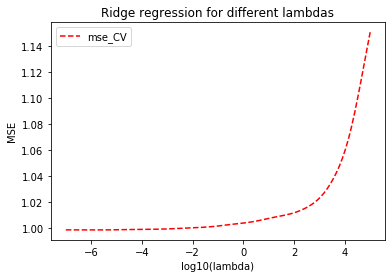

In [29]:
nlambdas = 100
lambdas = np.logspace(-7, 5, nlambdas)

mse_scores_CV = np.zeros((nlambdas, k))

i = 0
for lmb in lambdas:
    betaridge1 = np.linalg.inv(X_train_r.T.dot(X_train_r)+(lmb*np.eye(len(X_train_r[0])))).dot(X_train_r.T).dot(z_new_train)
    j = 0
    for train_inds, test_inds in kfold.split(X_new):
        Xtrain_r = X_new[train_inds]
        ztrain_r = z_1[train_inds]
        
        Xtest_r = X_new[test_inds]
        ztest_r = z_1[test_inds]
        
        zpred_r = Xtest_r @ betaridge1

        mse_scores_CV[i,j] = MSE(ztest_r, zpred_r)

        j += 1
    i += 1

estimated_mse_CV = np.mean(mse_scores_CV, axis = 1)

plt.figure()
plt.plot(np.log10(lambdas), estimated_mse_CV, 'r--', label = 'mse_CV')
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.title('Ridge regression for different lambdas')
plt.legend()
plt.show()

And we do the same with sk-learn to compare results

In [30]:
estimated_mse_sklearn = np.zeros(nlambdas)

i = 0
for lmb in lambdas:
    ridge = skl.Ridge(alpha = lmb)

    estimated_mse_folds = cross_val_score(ridge, X_new[:,1:], z_1, scoring='neg_mean_squared_error', cv=kfold)
    estimated_mse_sklearn[i] = np.mean(-estimated_mse_folds)
    i += 1

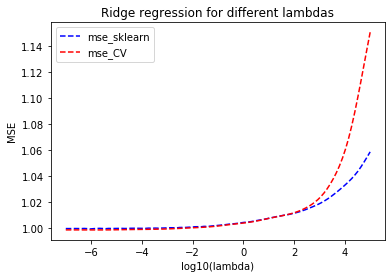

In [31]:
plt.figure()

plt.plot(np.log10(lambdas), estimated_mse_sklearn, 'b--', label = 'mse_sklearn')
plt.plot(np.log10(lambdas), estimated_mse_CV, 'r--', label = 'mse_CV')

plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.title('Ridge regression for different lambdas')
plt.legend()
plt.show()

Then we use gridsearch to find the exact best value for lambda

In [32]:
nlambdas = 50
lambdas = np.logspace(-7, 2, nlambdas)

param_grid = {'alpha': lambdas}

ridge = skl.Ridge()

ridge_regressor = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=kfold)
ridge_regressor.fit(X_new[:,1:], z_1)

print(ridge_regressor.best_params_)
print(ridge_regressor.best_score_)

{'alpha': 1.2648552168552959e-06}
-0.9995380446727817


### 5.2. Ridge as function of model complexity

We first create a new function to get the cross-validation for Ridge

In [33]:
def cross_validation_ridge(x, y, lmb, k):
    n = len(x)
    
    indexes = np.arange(y.shape[0])
    np.random.shuffle(indexes)
    x = x[indexes]
    y = y[indexes]
    
    r2_test = []
    mse_train = []
    mse_test = []
    
    bias = []
    variance = []
    for i in range(k):
        x_train = np.concatenate((x[:int(i*n/k)], x[int((i + 1)*n/k): ]), axis = 0)
        x_test = x[int(i*n/k):int((i + 1)*n/k)]
        y_train = np.concatenate((y[:int(i*n/k)], y[int((i + 1)*n/k): ]), axis = 0)
        y_test = y[int(i*n/k):int((i + 1)*n/k)]

        beta = np.linalg.inv(x_train.T.dot(x_train)+(lmb*np.eye(len(x_train[0])))).dot(x_train.T).dot(y_train)

        ytilde = x_train @ beta
        ypredict = x_test @ beta
        
        mse_train.append(MSE(y_train, ytilde))
        mse_test.append(MSE(y_test, ypredict))
        r2_test.append(R2(y_test, ypredict))
        
        bias.append(np.mean((y_test - np.mean(ypredict))**2))
        variance.append(np.mean(np.var(ypredict)))
    
    r2_test = np.array(r2_test)
    mse_train = np.array(mse_train)
    mse_test = np.array(mse_test)
    
    bias = np.array(bias)
    variance = np.array(variance)
        
    return r2_test, mse_train, mse_test, bias, variance

And then we can plot the MSE-score against the complexity, for different values of lambda

/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10
/Users/jolyndevis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in log10


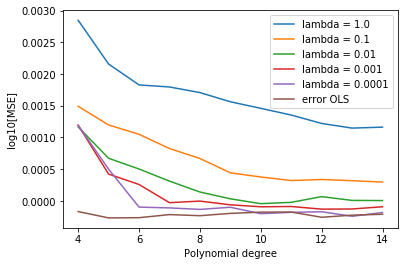

In [34]:
maxdegree = 15
polynomial = np.arange(maxdegree)

_lambdas = [1.0, 0.1, 0.01, 0.001, 0.0001]

CV_mse_ridge = np.zeros((maxdegree, len(_lambdas)))
CV_mse_OLS = np.zeros(maxdegree)

for degree in range(4, maxdegree):
    XR = CreateDesignMatrix_X(x_1, y_1, n=degree)  
    CV_mse_OLS[degree] = np.mean(cross_validation(X_new, z_1, k)[2])

    XR_train, XR_test, zR_train, zR_test, zR_true_train, zR_true_test = train_test_split(XR, z_1, z_true, test_size=0.2)
    
    #true_mse_ridge = []
    for i in range(len(_lambdas)):
        #betaridge_ = np.linalg.inv(XR_train.T.dot(XR_train)+(_lambdas[i]*np.eye(len(XR_train[0])))).dot(XR_train.T).dot(zR_train)
        #ridge_predict = XR_test @ betaridge_
        #true_mse_ridge[degree, i] = MSE(zR_true_test, ridge_predict)
        
        CV_mse_ridge[degree, i] = np.mean(cross_validation_ridge(XR, z_1, _lambdas[i], k)[2])


for i in range(len(_lambdas)):
    plt.plot(polynomial, np.log10(CV_mse_ridge[:,i]), label='lambda = {}'.format(_lambdas[i]))

plt.plot(polynomial, np.log10(CV_mse_OLS), label='error OLS')    #the matrix probably gets near-singular for a higher complexity, which is why the OLS error goes up real fast. we can try the SVD
plt.xlabel('Polynomial degree')
plt.ylabel('log10[MSE]')
#plt.title('Ridge regression')
plt.legend()
plt.show()   

### 5.3. Bias-variance and ridge

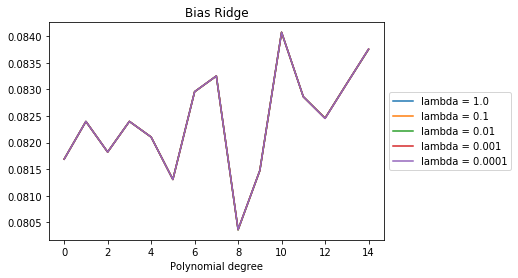

In [35]:
maxdegree = 15
polynomial = np.arange(maxdegree)


_lambdas = [1.0, 0.1, 0.01, 0.001, 0.0001]

error_ridge = np.zeros((maxdegree, len(_lambdas)))
bias_ridge = np.zeros((maxdegree, len(_lambdas)))
variance_ridge = np.zeros((maxdegree, len(_lambdas)))

for degree in range(maxdegree):
    XR1 = CreateDesignMatrix_X(x_1, y_1, n=degree)  
    XR1_train, XR1_test, zR1_train, zR1_test, zR1_true_train, zR1_true_test = train_test_split(XR1, z_1, z_true, test_size=0.2)
    
    for i in range(len(_lambdas)):
        betaridge_ = np.linalg.inv(XR1_train.T.dot(XR1_train)+(_lambdas[i]*np.eye(len(XR1_train[0])))).dot(XR1_train.T).dot(zR1_train)
        ridge_predict = XR1_test @ betaridge_
        
        error_ridge[degree, i] = MSE(zR1_test, ridge_predict)
        bias_ridge[degree, i] = np.mean((zR1_true_test - np.mean(ridge_predict))**2)
        variance_ridge[degree, i] = np.mean(np.var(ridge_predict))

for i in range(len(_lambdas)):
    #plt.plot(polynomial, error_ridge[:,i], label='lambda = {}'.format(_lambdas[i]))
    plt.plot(polynomial, bias_ridge[:,i], label='lambda = {}'.format(_lambdas[i]))
    #plt.plot(polynomial, variance_ridge[:,i], label='lambda = {}'.format(_lambdas[i]))

#plt.plot(polynomial, np.log10(true_mse), label='error OLS')    #the matrix probably gets near-singular for a higher complexity, which is why the OLS error goes up real fast. we can try the SVD
#plt.title('Bias-variance tradeoff Ridge')
#plt.title('Test error Ridge')
plt.title('Bias Ridge')
#plt.title('Variance Ridge')

plt.xlabel('Polynomial degree')
#plt.xlim(1,15)
#plt.ylabel('variance')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()   

#### Final settings for Ridge

Here we define the final settings for Ridge, with the optimal lambda value, so that we can use these results. 

In [36]:
lmb_ridge = 1e-7

mse_ridge = cross_validation_ridge(X_new[:,1:], z_1, lmb_ridge, k)[2]
r2_ridge = cross_validation_ridge(X_new[:,1:], z_1, lmb_ridge, k)[0]

ridge = skl.Ridge(alpha = lmb_ridge)
mse_ridge_sklearn = cross_val_score(ridge, X_new[:,1:], z_1, scoring='neg_mean_squared_error', cv=kfold)

print("MSE ridge: %0.5f (+/- %0.5f)" % (mse_ridge.mean(), mse_ridge.std()*2))
print("MSE ridge SKLearn: %0.5f (+/- %0.5f)" % (-(mse_ridge_sklearn.mean()), mse_ridge_sklearn.std()*2))

print("R2 ridge: %0.5f (+/- %0.5f)" % (r2_ridge.mean(), r2_ridge.std()*2))

MSE ridge: 1.00028 (+/- 0.02546)
MSE ridge SKLearn: 0.99941 (+/- 0.04593)
R2 ridge: 0.07692 (+/- 0.01395)


## 6. Lasso Regression 

We start by making the same plot as for ridge, to see how the MSE depends on lambda

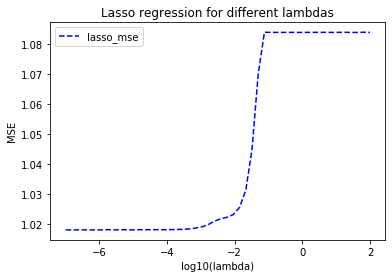

In [37]:
lasso_mse = np.zeros(nlambdas)

i = 0
for lmb in lambdas:
    lasso = skl.Lasso(alpha = lmb, precompute = True, tol = 10, max_iter = 10e3)

    lasso_mse_folds = cross_val_score(lasso, X_new[:,1:], z_1, scoring='neg_mean_squared_error', cv=kfold)
    lasso_mse[i] = np.mean(-lasso_mse_folds)
    i += 1

plt.figure()
plt.plot(np.log10(lambdas), lasso_mse, 'b--', label = 'lasso_mse')
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.title('Lasso regression for different lambdas')
plt.legend()
plt.show()

Then we find the optimal value for lambda for lasso, using GridSearchCV

In [38]:
nlambdas = 50
lambdas_lasso = np.logspace(-7, 2, nlambdas)
param_grid_lasso = {'alpha': lambdas_lasso}

lasso = skl.Lasso(precompute = True, tol = 10, max_iter = 10e3)

lasso_regressor = GridSearchCV(lasso, param_grid_lasso, scoring='neg_mean_squared_error', cv=kfold)
lasso_regressor.fit(X_new[:,1:], z_1)

print(lasso_regressor.best_params_)
print(lasso_regressor.best_score_)

{'alpha': 1e-07}
-1.0180043316295158


Then we implement this lambda 

In [39]:
l_lambda = 1e-7

clf_lasso = skl.Lasso(alpha=l_lambda, precompute = True, tol = 10, max_iter = 10e3).fit(X_new_train, z_new_train)
pred_lasso = clf_lasso.predict(X_new_test)


lasso_mse_folds = cross_val_score(clf_lasso, X_new[:,1:], z_1, scoring='neg_mean_squared_error', cv=kfold)
lasso_mse = np.mean(-lasso_mse_folds)

lasso_r2_folds = cross_val_score(clf_lasso, X_new[:,1:], z_1, cv=kfold)
lasso_r2 = np.mean(-lasso_r2_folds)

## 7. Comparing of models 

And now we can compare the three models with eachother, including **cross validation for all models**

In [40]:
print("MSE-score OLS: %0.5f (+/- %0.5f)" % (mse_test_ols.mean(), mse_test_ols.std()*2))

print("MSE ridge: %0.5f (+/- %0.5f)" % (mse_ridge.mean(), mse_ridge.std()*2))
print("MSE ridge SKLearn: %0.5f (+/- %0.5f)" % (-(mse_ridge_sklearn.mean()), mse_ridge_sklearn.std()*2))

print("MSE LASSO: %0.5f (+/- %0.5f)" % (-(lasso_mse_folds.mean()), lasso_mse_folds.std()*2))

MSE-score OLS: 0.99939 (+/- 0.04127)
MSE ridge: 1.00028 (+/- 0.02546)
MSE ridge SKLearn: 0.99941 (+/- 0.04593)
MSE LASSO: 1.01801 (+/- 0.03598)


In [41]:
print("R2-Score OLS: %0.5f (+/- %0.5f)" % (r2_ols.mean(), r2_ols.std()*2))

print("R2 ridge: %0.5f (+/- %0.5f)" % (r2_ridge.mean(), r2_ridge.std()*2))

print("R2 LASSO: %0.5f (+/- %0.5f)" % (lasso_r2_folds.mean(), lasso_r2_folds.std()*2))

R2-Score OLS: 0.07798 (+/- 0.01140)
R2 ridge: 0.07692 (+/- 0.01395)
R2 LASSO: 0.06053 (+/- 0.00866)


And we have a look at the different scores for the real data without the noise: 

In [42]:
print("True MSE OLS:", MSE(z_new_true_test, zpredict_new))
print("True MSE ridge:", MSE(z_new_true_test, ridge_predict))
print("True MSE lasso:", MSE(z_new_true_test, pred_lasso))

True MSE OLS: 0.0013866416358627857
True MSE ridge: 0.16872445958017085
True MSE lasso: 0.018811559097443142


In [43]:
print("True R2 OLS", R2(z_new_true_test, zpredict_new))
print("True R2 Ridge:", R2(z_new_true_test, ridge_predict))
print("True R2 lasso:", R2(z_new_true_test, pred_lasso))

True R2 OLS 0.9832436263936684
True R2 Ridge: -1.038487169126887
True R2 lasso: 0.7726742384058312
